# Reprojecting
## Import data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# Import countries shapefile
fp = os.path.join('data','ne_50m_admin_0_countries','ne_50m_admin_0_countries.shp')
countries = gpd.read_file(fp)
countries.columns = countries.columns.str.lower()  # Simplify column names
countries = countries[['admin', 'type', 'geometry']]
countries.head(3)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."


In [3]:
# Import Arctic communities GeoJSON directly from URL
URL = 'https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed7718ae-fb0d-43dd-9270-fbfe80bfc7a4'
communities = gpd.read_file(URL)
communities.head()

,name,population,country,geoname-id,geometry
0,Udomlya,32373,RU,452949,POINT (34.99250 57.87944)
1,Valmiera,26963,LV,453754,POINT (25.42751 57.54108)
2,Ventspils,42644,LV,454310,POINT (21.57288 57.38988)
3,Vec-Liepāja,85260,LV,454432,POINT (21.01667 56.53333)
4,Tukums,18348,LV,454768,POINT (23.15528 56.96694)


In [4]:
# Import country names from URL
URL = 'https://raw.githubusercontent.com/MEDS-eds-220/MEDS-eds-220-course/refs/heads/main/book/chapters/lesson-12-merge-data/country_names.csv'
country_names = pd.read_csv(URL)
country_names.head()

,country,admin
0,RU,Russia
1,LV,Latvia
2,EE,Estonia
3,LT,Lithuania
4,SE,Sweden


<Axes: >

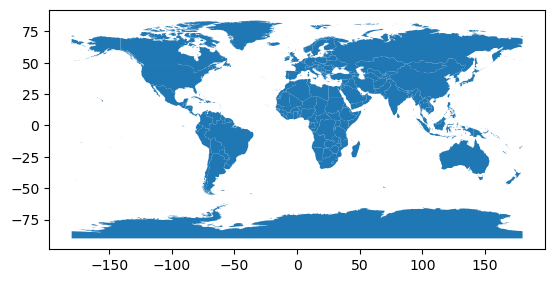

In [5]:
# Quick view
countries.plot()

The CRS of the `communities` is EPSG:4326. Remember all GeoJSON files are given in this CRS and all points are expressed in longitude and latitude units of decimal degrees.

In [6]:
print(countries.crs)

EPSG:4326


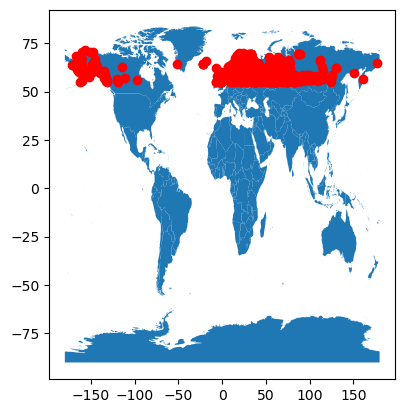

In [7]:
# Verify CRSs match
assert countries.crs == communities.crs

fig, ax = plt.subplots()
countries.plot(ax=ax)
communities.plot(ax=ax, color='red')
plt.show()

## Arctic communities by country
Next, we want to calculate the number of Arctic communities per country. 

In [ ]:
# Create data frame with number of communities per country
n_comms = (communities.groupby('country')
           .size()
           .reset_index(name = 'n_communities'))

Let’s break this down:

- We start with our communities dataframe and use groupby('country') to group by country code.
- Then we use size() as an aggregator function to calculate the size of each group.
- The result of this operation is a pandas.Series indexed by the country values.
- By resetting the index we transform the pandas.Series into a pandas.DataFrame, the index is now a column named country and the values of the series are named n_communities.

In [9]:
# Number of Arctic communities per country
n_comms

,country,n_communities
0,AX,1
1,BY,8
2,CA,7
3,DK,72
4,EE,14
5,FI,98
6,FO,1
7,GB,96
8,GL,1
9,IS,5


### if-else statements

Our goal is to merge the n_comms and the countries data frames. To merge two data frames they need to have at least one column in common. Currently our datasets do not have any columns in common:

In [11]:
set(countries.columns).intersection(n_comms.columns)

set()

The output set() represents the empty set. This might not be as informative, so let’s write a different information statement:

In [12]:
common_columns  = set(countries.columns).intersection(n_comms.columns)
# Check of there are any common columnd

if len(common_columns) != 0:
    print(f"Common columns: {common_columns}")
else:
    print("No common columns")

No common columns


Remember that an if-else statement is a control structure that allows code to make decisions: it checks a condition, and if that condition is true, it executes one block of code (the if block); if the condition is false, it executes a different block (the else block). This enables programs to respond differently depending on specific criteria or inputs.

#### Check-in
Wrap up the previous code into a function called `check_common_columns` that prints a message depending of whether two data frames have common columns or not. Don’t forget to include a docstring!

In [18]:
def check_common_columns(df1, df2):
    common_columns = set(df1.columns).intersection(df2.columns)
    if len(common_columns) != 0:
        print(f"Common columns: {common_columns}")
    else:
        print("No common columns")

### Merging data frames
We can use the `country_names` data frame to add the names countries into the `n_comms`v data which, in turn, will allow us to merge that data frame with the `country_names` data. To merge dataframes we can use the `pandas.merge()` function. The basic syntax for it is:

```
output_df = pd.merge(left_df, # df on the "left" side
                     right_df, # df on the "right"
                     how = type_of_join, # default = inner join
                     on = column_to_join) # which column to join on, must me in both df's
```

where

- output_df is the dataframe resulting from the merge,
- left_df is the dataframe we have “on the left side”,
- right_df is the dataframe we have “on the right side”,
- how specifies the type of join between the left and right dataframes, (check the options here), the default is to do an inner join,
- on specifies the column to join on, this column must be present in both our dataframes.
When merging a geopandas.GeoDataFrame with a pandas.DataFrame, the geopandas.GeoDataFrame must be “on the left” to retain the geospatial information. Otherwise, the output will be a pandas.DataFrame.

So, we merge the n_comms and country_names data frames using a left join:



In [16]:
n_comms = pd.merge(n_comms,
                   country_names,
                   how='left',
                   on='country')
n_comms

,country,n_communities,admin
0,AX,1,Aland Islands
1,BY,8,Belarus
2,CA,7,Canada
3,DK,72,Denmark
4,EE,14,Estonia
5,FI,98,Finland
6,FO,1,Faroe Islands
7,GB,96,United Kingdom
8,GL,1,Greenland
9,IS,5,Iceland


We can reuse our function to check that `n_comms` and `countries` now have a common column on which we can merge them:

In [19]:
check_common_columns(n_comms, countries)

Common columns: {'admin'}


#### Check-in
Create a new variable named `arctic_countries` which is the result of an inner join between our countries and n_comms dataframes. The inner joun will merge the subset of rows that have matches in both the left table and the right table.

In [25]:
arctic_countries = pd.merge(countries, # df on the "left" side
                     n_comms, # df on the "right"
                     how = 'inner', # default = inner join
                     on = 'admin') # which column to join on, must me in both df's
arctic_countries.head()

,admin,type,geometry,country,n_communities
0,United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
1,United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
2,Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133
3,Russia,Sovereign country,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ...",RU,774
4,Norway,Sovereign country,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...",NO,48


In [20]:
countries.head()

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Vietnam,Sovereign country,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Venezuela,Sovereign country,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


In [21]:
n_comms.head()

,country,n_communities,admin
0,AX,1,Aland Islands
1,BY,8,Belarus
2,CA,7,Canada
3,DK,72,Denmark
4,EE,14,Estonia


The `values` attribute of a data frame returns *all* the values in the data frame as an array. We can verify the value ‘Aland Islands’ was *nowhere* in our original countries dataframe like this:

In [26]:
# Check Aland Islands is nowhere in data frame
'Aland Islands' not in countries.values

True

The Aland Islands is an autonomous region of Finland and there is one Arctic community registered in this region. We will directly add one to Finland to not lose this piece of data:

In [28]:
arctic_countries.at['Finland', 'n_communities'] += 1 # don't re-run because it's going to add the column again 

KeyError: 'Finland'

### Choropleth map
A choropleth map is an efficient way to visualize aggregate data per region.

Making a choropleth map from our polygons GeoDataFrame is easy; we just need to specify the column parameter in plot() and make it equal to the column with the values we want to plot in each country:

<Axes: >

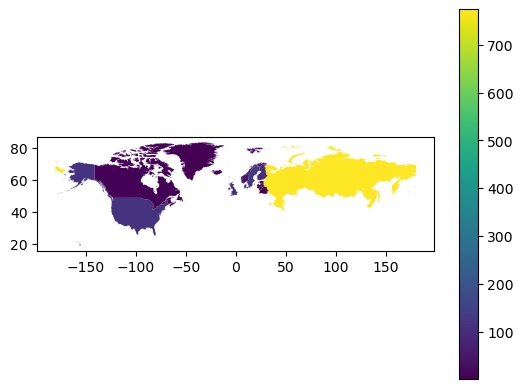

In [27]:
arctic_countries.plot(column = 'n_communities', 
                      legend = True)

### Reprojecting
Remember that CRSs reflect cultural views and even biases. Any map projection involves choices about which areas to emphasize, minimize, or distort, and those choices can influence how viewers perceive different regions. In our map, using the EPSG:4326 CRS is, among other things, mapping the Arctic regions as far apart, while they are actually near each other.

Reprojecting means changing the coordinate reference system of your geospatial data. In our case, we will reproject the Alaska geo-dataframe to the CRS EPSG:3413. This CRS is a projected CRS, better suited for working with data from the Arctic region:

Changing CRSs in GeoPandas is very simple using the to_crs() method for geopandas.GeoDataFrames. The general syntax is:
```
updated_geodf = geodf.to_crs(new_crs)
```
where:

- updated_geodf is the output of the method, a new geodataframe (to_crs() does not work in place),
- geodf is the geopandas.GeoDataFrame we want to transform,
- new_crs is the CRS we want to convert to, this is an object of type CRS or string representing the CRS (ex: 'epsg:3413').

In our case:

In [29]:
# Reproject to CRS for Arctic region
arctic_region = arctic_countries.to_crs('epsg:3413')

<Axes: >

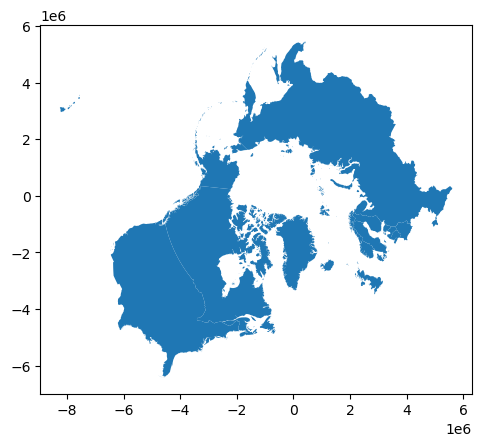

In [31]:
arctic_region.plot()

We can now use the reprojected data to update our map:

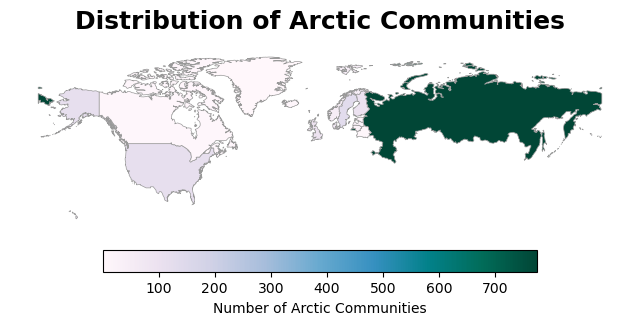

In [32]:
ffig, ax = plt.subplots(figsize=(8, 6))

# Remove the axis for a cleaner map
ax.axis('off')

# Create choropleth map of communities
# Plot with refined color and edge style
arctic_countries.plot(
    ax=ax,
    column='n_communities',
    cmap='PuBuGn',
    legend=True,
    edgecolor="0.6",
    linewidth=0.5,
    legend_kwds={
        "shrink": 0.7,
        "label": "Number of Arctic Communities",
        "orientation": "horizontal",
        "pad": 0.05
    }
)

# Add title and subtitle for better context
ax.set_title('Distribution of Arctic Communities', fontsize=18, weight='bold', pad=15)

plt.show()

Although the new projection clearly improves the presentation of the data, there are still issues with this plot! Mainly, the entire United States territory is in it, when we should only have Alaska. In our next lesson we will review startegies to clip and subset vector data and return to this plot in our discussion section